In [1]:
import torch

# Kiểm tra phiên bản torch
print("Torch version:", torch.__version__)

# Kiểm tra xem có sử dụng GPU không
print("CUDA available:", torch.cuda.is_available())

# Kiểm tra phiên bản CUDA tương thích với torch
print("CUDA version:", torch.version.cuda)

# Kiểm tra số lượng GPU có thể sử dụng
print("Number of GPUs:", torch.cuda.device_count())

# Kiểm tra tên GPU đang sử dụng
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


Torch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Number of GPUs: 1
GPU Name: Tesla P100-PCIE-16GB


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import random

In [ ]:
# Thiết lập seed để đảm bảo tính tái lập
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Các phép biến đổi với Tăng cường dữ liệu và Chuẩn hóa
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Tải bộ dữ liệu CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

100%|██████████| 170M/170M [00:08<00:00, 20.4MB/s] 


In [ ]:
# Patch Embedding giống Vision Transformer
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_size=256, img_size=64):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, emb_size))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)  # [B, emb_size, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, emb_size]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embedding
        return x

# Bộ phân loại ảnh Transformer
class ImageTransformerClassifier(nn.Module):
    def __init__(self, emb_size=256, num_heads=8, hidden_dim=512, num_layers=6, num_classes=10, dropout=0.1):
        super().__init__()
        self.embedding = PatchEmbedding(emb_size=emb_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=num_heads,
                                                   dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        cls_token_final = x[:, 0, :]  # Chỉ sử dụng token lớp
        return self.fc(cls_token_final)

# Thiết lập mô hình
model = ImageTransformerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
# Vòng lặp huấn luyện
def train(model, loader):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="Training", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader)

# Vòng lặp đánh giá
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    loop = tqdm(loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            preds.extend(pred.cpu().numpy())
            targets.extend(y.cpu().numpy())
    return accuracy_score(targets, preds)

# Chạy huấn luyện
epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}")
    loss = train(model, train_loader)
    acc = evaluate(model, test_loader)
    scheduler.step()
    print(f"Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")


Epoch 1


Loss: 1.7592 - Test Accuracy: 0.4510

Epoch 2


Loss: 1.4189 - Test Accuracy: 0.5480

Epoch 3


Loss: 1.2430 - Test Accuracy: 0.5800

Epoch 4


Loss: 1.1411 - Test Accuracy: 0.6116

Epoch 5


Loss: 1.0417 - Test Accuracy: 0.6195

Epoch 6


Loss: 0.9602 - Test Accuracy: 0.6583

Epoch 7


Loss: 0.8888 - Test Accuracy: 0.6769

Epoch 8


Loss: 0.8267 - Test Accuracy: 0.6923

Epoch 9


Loss: 0.7784 - Test Accuracy: 0.7004

Epoch 10


Loss: 0.7495 - Test Accuracy: 0.7076


In [6]:
torch.save(model.state_dict(), "image_transformer_cifar10.pth")

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Ánh xạ nhãn CIFAR-10
classes = train_dataset.classes  # ['airplane', 'automobile', ..., 'truck']

def predict_image(model, image_tensor):
    model.eval()
    with torch.no_grad():
        if isinstance(image_tensor, torch.Tensor):
            img = image_tensor.unsqueeze(0).to(device)  # [1, C, H, W]
        else:
            raise TypeError("Expected a torch.Tensor as input.")
        output = model(img)
        pred = torch.argmax(output, dim=1).item()
    return pred, output.softmax(dim=1).squeeze()[pred].item()

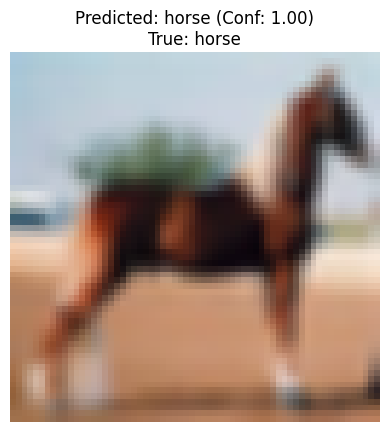

In [ ]:
# Tải mô hình
model = ImageTransformerClassifier()
model.load_state_dict(torch.load("image_transformer_cifar10.pth",weights_only=True))
model.eval()
model.to(device)

# Hàm hoàn tác chuẩn hóa
def unnormalize(tensor):
    # Mean và Std phải giống hệt lúc khai báo transform
    mean = torch.tensor((0.4914, 0.4822, 0.4465)).view(3, 1, 1)
    std = torch.tensor((0.2023, 0.1994, 0.2010)).view(3, 1, 1)
    
    # Công thức ngược: Pixel = (Normalized * Std) + Mean
    tensor = tensor.cpu() * std + mean
    return tensor.clamp(0, 1) # Đảm bảo giá trị nằm trong [0, 1]

# --- Sửa lại đoạn hiển thị ---
idx = random.randint(0, len(test_dataset) - 1)
img, label = test_dataset[idx]

# Dự đoán (vẫn dùng ảnh đã normalize để đưa vào model)
pred_idx, confidence = predict_image(model, img)

# Hiển thị (Dùng ảnh đã un-normalize để mắt người nhìn thấy tự nhiên)
img_display = unnormalize(img) 
plt.imshow(TF.to_pil_image(img_display))
plt.title(f"Predicted: {classes[pred_idx]} (Conf: {confidence:.2f})\nTrue: {classes[label]}")
plt.axis("off")
plt.show()